In [ ]:
# Imports

import pandas as pd
import numpy as np
import seaborn as sns
import json
import collections
import matplotlib.pyplot as plt
import seaborn as sns
import re
#import langdetect
from textblob import TextBlob
import spacy
from sklearn import feature_extraction, manifold
import gensim.downloader as gensim_api
import gensim

#nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import tokenize
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer, SentimentIntensityAnalyzer
from nltk.sentiment.util import *

#sci-kit learn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import (accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc,
                             mean_squared_error, log_loss, precision_recall_curve, classification_report,
                             precision_recall_fscore_support,ConfusionMatrixDisplay)
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier, Perceptron, PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.pipeline import make_pipeline

# Word2vec
from gensim.models import Word2Vec, FastText
from sklearn.decomposition import PCA
import plotly.graph_objects as go
#FastText
from keras.preprocessing.text import Tokenizer
from gensim.models.fasttext import FastText
from string import punctuation
from nltk import WordPunctTokenizer

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import word2vec
from gensim.models import *
import logging
%matplotlib inline

from collections import Counter
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from datetime import datetime

## Set Up and Read Data

In [ ]:
# Load the datasets
with open("movies.json", "r") as f:
    movies_data = json.load(f)

with open("qa.json", "r") as f:
    qa_data = json.load(f)

# Merge the data based on imdb_key
for movie in movies_data:
    # Use a list comprehension to find all matching QA entries
    matching_qa = [
        {'question': qa['question'], 'answers': qa['answers'], 'correct_index': qa['correct_index']}
        for qa in qa_data if qa['imdb_key'] == movie['imdb_key']
    ]

    # Add the matching QA entries to the movie dictionary
    movie['questions'] = matching_qa

# To check the data
# Convert the movies data to a DataFrame
df = pd.DataFrame(movies_data)

# Display the first 5 movies
df.head(5)

,genre,text,imdb_key,name,year,questions
0,"Action, Drama, Thriller","{'plot': 'story/plot/tt2614684.wiki', 'subtitl...",tt2614684,'71,2014,[{'question': 'Why does Hook leave Eamon's apa...
1,"Comedy, Drama, Romance","{'plot': 'story/plot/tt1022603.wiki', 'subtitl...",tt1022603,(500) Days of Summer,2009,[{'question': 'Whose relationship does the mov...
2,"Comedy, Drama, Romance","{'plot': 'story/plot/tt0147800.wiki', 'subtitl...",tt0147800,10 Things I Hate About You,1999,[{'question': 'Why does Joey reveal his arrang...
3,"Comedy, Crime, Drama","{'plot': 'story/plot/tt0331811.wiki', 'subtitl...",tt0331811,11:14,2003,[{'question': 'Who killed Norma's daughter Che...
4,"Biography, Drama, History","{'plot': 'story/plot/tt2024544.wiki', 'subtitl...",tt2024544,12 Years a Slave,2013,[{'question': 'What instrument does Solomon pl...


In [ ]:
# Print the number of movies and average number of questions per movie
num_movies = len(movies_data)
avg_questions = sum(len(movie['questions']) for movie in movies_data) / num_movies
print(f"Number of movies: {num_movies}")
print(f"Average number of questions per movie: {avg_questions:.2f}")


Number of movies: 408
Average number of questions per movie: 36.63


##  Text Preprocessing

Clean, tokenize, remove stopwords, and lemmatize the text.

In [ ]:
# Load NLTK's English stopwords
lst_stopwords = set(stopwords.words('english'))
# custom list of stopwords
custom_stopwords = ["question", "answer", "plot_alignment", "correct_index", "qid" , 'imdb_key','video_clips']  # Replace these with your own words

# Add custom stopwords to the set
lst_stopwords.update(custom_stopwords)

print(lst_stopwords)

{'it', 'in', 'hasn', 'those', "needn't", 'shan', 'out', 'y', 'again', "doesn't", "wasn't", 'where', 'same', "you'll", 'these', 'wouldn', 'over', 'on', 'mustn', 'its', 'whom', 't', "haven't", "didn't", 'with', 'own', 'answer', 'hers', 'if', 's', 'from', "don't", 'yourselves', 'after', 'once', 'all', 'm', 'weren', 'the', 'for', 'correct_index', 'under', 'plot_alignment', 'o', 'just', 'didn', 'about', "shouldn't", 'she', 'a', 'haven', "shan't", "isn't", 'most', 'of', 'couldn', 'their', 'does', 'while', 'should', 'yours', 'don', 'imdb_key', "it's", 'did', 'won', 'but', 'can', 'herself', 'more', 'theirs', 'her', 'this', 'be', 'how', 'shouldn', 'other', 'your', 'do', 'up', 'he', 'themselves', "weren't", 'him', 'had', 're', 'between', 'until', 'them', 'were', 'too', "won't", 'because', 'why', 'each', 'aren', 'by', 'qid', 'so', 'than', 'ain', 'question', 'into', 'then', "couldn't", 'been', 'few', 'or', 'isn', 'myself', 'video_clips', 'below', 'off', 'here', "that'll", 'no', 'further', "you're"

In [ ]:
def utils_preprocess_questions(questions, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    questions = re.sub(r'[^\w\s]', '', str(questions).lower().strip())
    lst_questions = questions.split()
    if lst_stopwords is not None:
        lst_questions = [word for word in lst_questions if word not in lst_stopwords]
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_questions = [ps.stem(word) for word in lst_questions]
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_questions = [lem.lemmatize(word) for word in lst_questions]
    text = " ".join(lst_questions)
    return text

df["questions_clean"] = df["questions"].apply(lambda x: utils_preprocess_questions(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))
df.head()

,genre,text,imdb_key,name,year,questions,questions_clean
0,"Action, Drama, Thriller","{'plot': 'story/plot/tt2614684.wiki', 'subtitl...",tt2614684,'71,2014,[{'question': 'Why does Hook leave Eamon's apa...,hook leave eamons apartment answer warned safe...
1,"Comedy, Drama, Romance","{'plot': 'story/plot/tt1022603.wiki', 'subtitl...",tt1022603,(500) Days of Summer,2009,[{'question': 'Whose relationship does the mov...,whose relationship movie cover answer paul sum...
2,"Comedy, Drama, Romance","{'plot': 'story/plot/tt0147800.wiki', 'subtitl...",tt0147800,10 Things I Hate About You,1999,[{'question': 'Why does Joey reveal his arrang...,joey reveal arrangement patrick prom answer bi...
3,"Comedy, Crime, Drama","{'plot': 'story/plot/tt0331811.wiki', 'subtitl...",tt0331811,11:14,2003,[{'question': 'Who killed Norma's daughter Che...,killed norma daughter cheri answer eddie mark ...
4,"Biography, Drama, History","{'plot': 'story/plot/tt2024544.wiki', 'subtitl...",tt2024544,12 Years a Slave,2013,[{'question': 'What instrument does Solomon pl...,instrument solomon play answer violincello bas...


## Explanatory Data Analysis (EDA)

In [ ]:
print(df.head())
#Check for missing values:
print(df.isnull().sum())
#Describe numerical data:
print(df.describe())

                       genre  \
0    Action, Drama, Thriller   
1     Comedy, Drama, Romance   
2     Comedy, Drama, Romance   
3       Comedy, Crime, Drama   
4  Biography, Drama, History   

                                                text   imdb_key  \
0  {'plot': 'story/plot/tt2614684.wiki', 'subtitl...  tt2614684   
1  {'plot': 'story/plot/tt1022603.wiki', 'subtitl...  tt1022603   
2  {'plot': 'story/plot/tt0147800.wiki', 'subtitl...  tt0147800   
3  {'plot': 'story/plot/tt0331811.wiki', 'subtitl...  tt0331811   
4  {'plot': 'story/plot/tt2024544.wiki', 'subtitl...  tt2024544   

                         name  year  \
0                         '71  2014   
1        (500) Days of Summer  2009   
2  10 Things I Hate About You  1999   
3                       11:14  2003   
4            12 Years a Slave  2013   

                                           questions  \
0  [{'question': 'Why does Hook leave Eamon's apa...   
1  [{'question': 'Whose relationship does the mov...   
2

In [ ]:
# Top N Genres
top_N = 10
print(f"Top {top_N} Genres:")
print(df['genre'].value_counts().head(top_N))
print("\n")

# Total Number of Unique Genres
print(f"Total Number of Unique Genres: {df['genre'].nunique()}")
print("\n")

# Genre Summary
print("Genre Distribution Summary:")
print(df['genre'].value_counts().describe())

Top 10 Genres:
Comedy, Romance                    34
Comedy, Drama, Romance             30
Drama, Romance                     23
Drama                              15
Crime, Drama, Mystery, Thriller    14
Comedy                             12
Crime, Drama                       11
Action, Adventure, Sci-Fi          10
Drama, Thriller                     9
Action, Adventure, Fantasy          8
Name: genre, dtype: int64


Total Number of Unique Genres: 135


Genre Distribution Summary:
count    135.000000
mean       3.022222
std        4.808988
min        1.000000
25%        1.000000
50%        1.000000
75%        3.000000
max       34.000000
Name: genre, dtype: float64


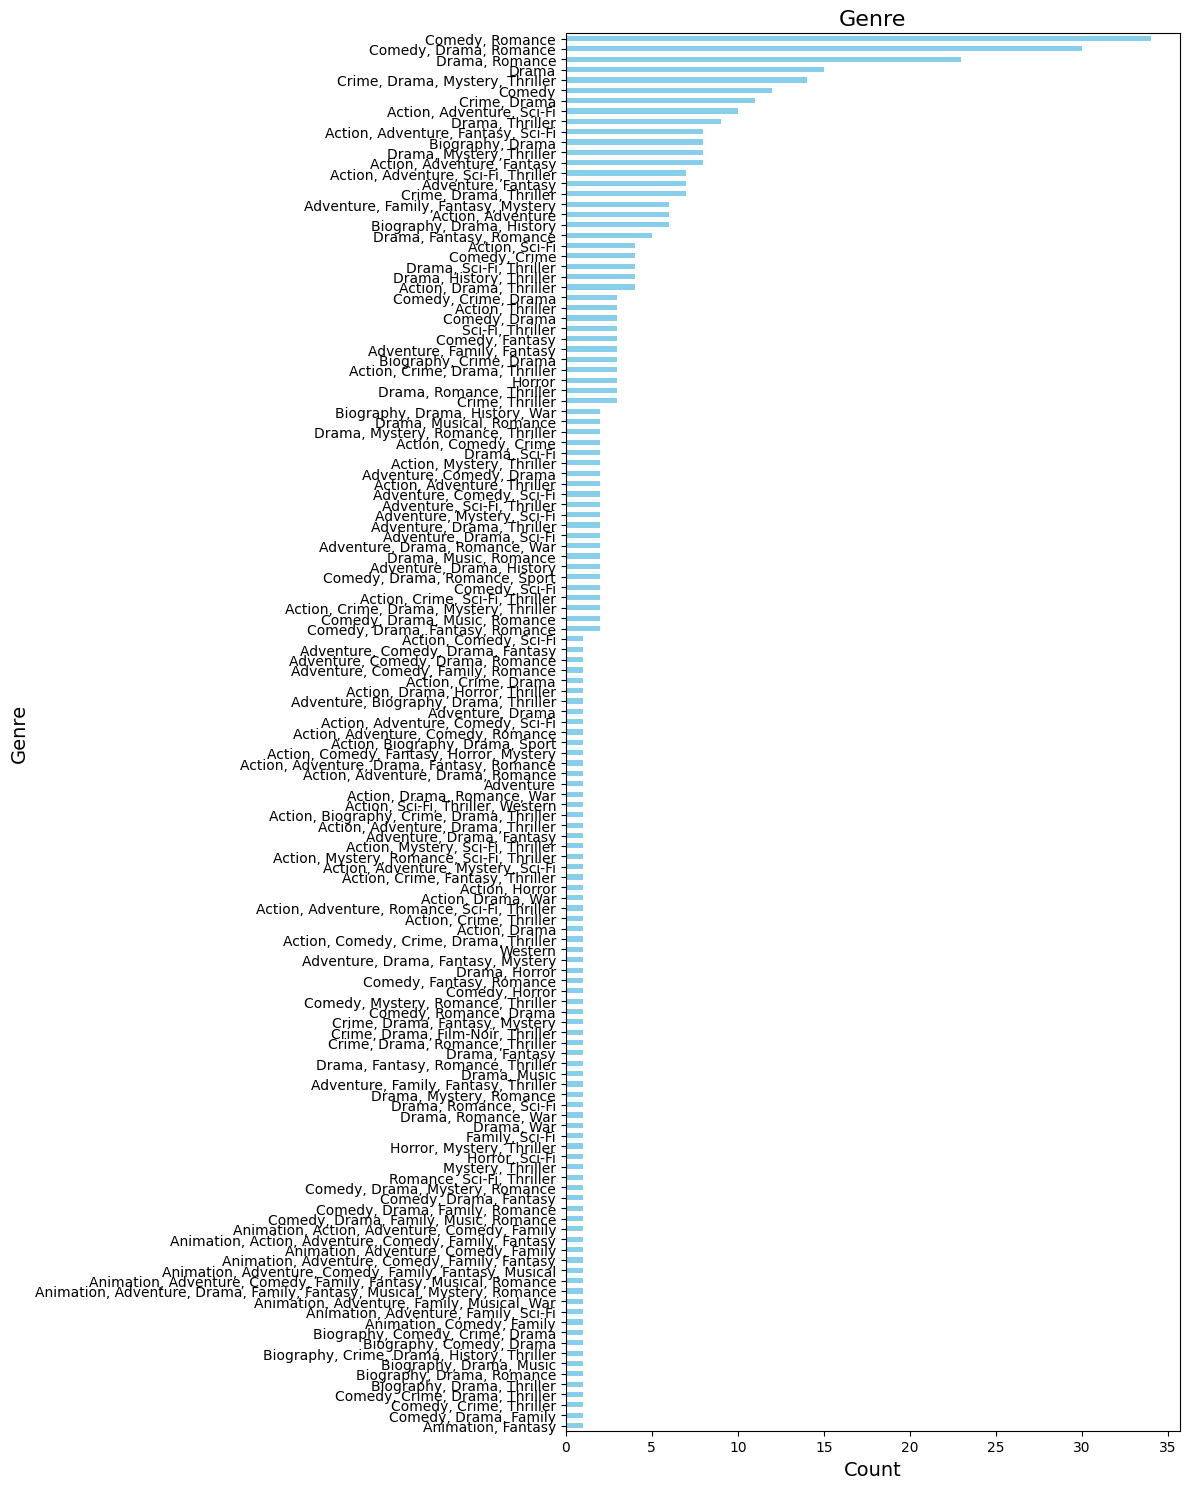

In [ ]:
# Step 1: Increase the figure size
fig, ax = plt.subplots(figsize=(12, 15))  # Adjust the size based on your needs

# Your existing code for generating the bar chart
df['genre'].reset_index().groupby('genre').count().sort_values(by='index').plot(kind='barh', legend=False, ax=ax, color='skyblue')  # Step 5: Add color

# Step 2: Rotate the labels (if needed)
# ax.set_yticklabels(ax.get_yticklabels(), rotation=45)  # Uncomment if you want to rotate y labels

# Step 3: Increase font size for axes
ax.set_xlabel('Count', fontsize=14)
ax.set_ylabel('Genre', fontsize=14)
ax.set_title('Genre', fontsize=16)

# Display the plot
plt.tight_layout()
plt.show()



## Feature Engineering and Selection

In [ ]:
#Length Analysis
df['word_count'] = df["questions"].apply(lambda x: len(str(x).split(" ")))
df['char_count'] = df["questions"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
df['sentence_count'] = df["questions"].apply(lambda x: len(str(x).split(".")))
df['avg_word_length'] = df['char_count'] / df['word_count']
df['avg_sentence_length'] = df['word_count'] / df['sentence_count']
df.head()

,genre,text,imdb_key,name,year,questions,questions_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length
0,"Action, Drama, Thriller","{'plot': 'story/plot/tt2614684.wiki', 'subtitl...",tt2614684,'71,2014,[{'question': 'Why does Hook leave Eamon's apa...,hook leave eamons apartment answer warned safe...,2121,11837,109,5.580858,19.458716
1,"Comedy, Drama, Romance","{'plot': 'story/plot/tt1022603.wiki', 'subtitl...",tt1022603,(500) Days of Summer,2009,[{'question': 'Whose relationship does the mov...,whose relationship movie cover answer paul sum...,468,2866,16,6.123932,29.250000
2,"Comedy, Drama, Romance","{'plot': 'story/plot/tt0147800.wiki', 'subtitl...",tt0147800,10 Things I Hate About You,1999,[{'question': 'Why does Joey reveal his arrang...,joey reveal arrangement patrick prom answer bi...,3697,20172,111,5.456316,33.306306
3,"Comedy, Crime, Drama","{'plot': 'story/plot/tt0331811.wiki', 'subtitl...",tt0331811,11:14,2003,[{'question': 'Who killed Norma's daughter Che...,killed norma daughter cheri answer eddie mark ...,668,3565,22,5.336826,30.363636
4,"Biography, Drama, History","{'plot': 'story/plot/tt2024544.wiki', 'subtitl...",tt2024544,12 Years a Slave,2013,[{'question': 'What instrument does Solomon pl...,instrument solomon play answer violincello bas...,2478,13795,20,5.566990,123.900000


In [ ]:
#Sentiment Analysis
df["sentiment"] = df["questions_clean"].apply(lambda x: TextBlob(x).sentiment.polarity)
df.head()

,genre,text,imdb_key,name,year,questions,questions_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length,sentiment
0,"Action, Drama, Thriller","{'plot': 'story/plot/tt2614684.wiki', 'subtitl...",tt2614684,'71,2014,[{'question': 'Why does Hook leave Eamon's apa...,hook leave eamons apartment answer warned safe...,2121,11837,109,5.580858,19.458716,-0.091168
1,"Comedy, Drama, Romance","{'plot': 'story/plot/tt1022603.wiki', 'subtitl...",tt1022603,(500) Days of Summer,2009,[{'question': 'Whose relationship does the mov...,whose relationship movie cover answer paul sum...,468,2866,16,6.123932,29.250000,0.045707
2,"Comedy, Drama, Romance","{'plot': 'story/plot/tt0147800.wiki', 'subtitl...",tt0147800,10 Things I Hate About You,1999,[{'question': 'Why does Joey reveal his arrang...,joey reveal arrangement patrick prom answer bi...,3697,20172,111,5.456316,33.306306,0.048650
3,"Comedy, Crime, Drama","{'plot': 'story/plot/tt0331811.wiki', 'subtitl...",tt0331811,11:14,2003,[{'question': 'Who killed Norma's daughter Che...,killed norma daughter cheri answer eddie mark ...,668,3565,22,5.336826,30.363636,-0.115625
4,"Biography, Drama, History","{'plot': 'story/plot/tt2024544.wiki', 'subtitl...",tt2024544,12 Years a Slave,2013,[{'question': 'What instrument does Solomon pl...,instrument solomon play answer violincello bas...,2478,13795,20,5.566990,123.900000,0.028399


In [ ]:
# Named Entity Recognition (NER)
import spacy
nlp = spacy.load("en_core_web_sm")
df["tags"] = df["questions_clean"].apply(lambda x: [(tag.text, tag.label_) for tag in nlp(x).ents])

def utils_lst_count(lst):
    dic_counter = collections.Counter()
    for x in lst:
        dic_counter[x] += 1
    dic_counter = collections.OrderedDict(sorted(dic_counter.items(), key=lambda x: x[1], reverse=True))
    lst_count = [{key:value} for key,value in dic_counter.items()]
    return lst_count

df["tags"] = df["tags"].apply(lambda x: utils_lst_count(x))
tags_set = []
for lst in df["tags"].tolist():
    for dic in lst:
        for k in dic.keys():
            tags_set.append(k[1])
tags_set = list(set(tags_set))
# Add defined function
def utils_nlp_features(lst, feature):
    for dic in lst:
        for (entity_text, entity_label), count in dic.items():
            if entity_label == feature:
                return count
    return 0

# (Continue with the rest of your NER code)
for feature in tags_set:
    df["tags_"+feature] = df["tags"].apply(lambda x: utils_nlp_features(x, feature))


In [ ]:
#Display the Top Rows of the DataFrame:
print(df.head())

#Display the NER Tags of a Specific Row:
row_index = 5  # for example
print(df.loc[row_index, 'tags'])

#Display Columns with Entity Counts:
entity_columns = ['tags_' + feature for feature in tags_set]
print(df[entity_columns].head())



                       genre  \
0    Action, Drama, Thriller   
1     Comedy, Drama, Romance   
2     Comedy, Drama, Romance   
3       Comedy, Crime, Drama   
4  Biography, Drama, History   

                                                text   imdb_key  \
0  {'plot': 'story/plot/tt2614684.wiki', 'subtitl...  tt2614684   
1  {'plot': 'story/plot/tt1022603.wiki', 'subtitl...  tt1022603   
2  {'plot': 'story/plot/tt0147800.wiki', 'subtitl...  tt0147800   
3  {'plot': 'story/plot/tt0331811.wiki', 'subtitl...  tt0331811   
4  {'plot': 'story/plot/tt2024544.wiki', 'subtitl...  tt2024544   

                         name  year  \
0                         '71  2014   
1        (500) Days of Summer  2009   
2  10 Things I Hate About You  1999   
3                       11:14  2003   
4            12 Years a Slave  2013   

                                           questions  \
0  [{'question': 'Why does Hook leave Eamon's apa...   
1  [{'question': 'Whose relationship does the mov...   
2

In [ ]:
#Aggregated View:
entity_counts = df[entity_columns].sum()
print(entity_counts)

tags_QUANTITY        239
tags_MONEY            68
tags_ORDINAL         467
tags_GPE            1094
tags_CARDINAL       3142
tags_PERSON         2616
tags_PERCENT          14
tags_NORP            951
tags_TIME            171
tags_ORG            1131
tags_LANGUAGE         51
tags_DATE            550
tags_PRODUCT         126
tags_FAC              72
tags_WORK_OF_ART      18
tags_EVENT            39
tags_LAW              27
tags_LOC             100
dtype: int64


In [ ]:
#Visual Display using Spacy's Displacy:
from spacy import displacy
sample_texts = df['questions_clean'].sample(5)
for text in sample_texts:
    doc = nlp(text)
    displacy.render(doc, style="ent", jupyter=True)


In [ ]:
# Constructing the TF-IDF model
vectorizer = TfidfVectorizer(max_features=10000)  # Setting a limit on max features for efficiency
tfidf_matrix = vectorizer.fit_transform(df['questions_clean'])
feature_names = vectorizer.get_feature_names_out()
df_vectorized = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
df = pd.concat([df, df_vectorized], axis=1)
df

,genre,text,imdb_key,name,year,questions,questions_clean,word_count,char_count,sentence_count,...,zoil,zombie,zone,zoo,zooey,zook,zubrowka,zuckerberg,zurich,zuse
0,"Action, Drama, Thriller","{'plot': 'story/plot/tt2614684.wiki', 'subtitl...",tt2614684,'71,2014,[{'question': 'Why does Hook leave Eamon's apa...,hook leave eamons apartment answer warned safe...,2121,11837,109,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Comedy, Drama, Romance","{'plot': 'story/plot/tt1022603.wiki', 'subtitl...",tt1022603,(500) Days of Summer,2009,[{'question': 'Whose relationship does the mov...,whose relationship movie cover answer paul sum...,468,2866,16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Comedy, Drama, Romance","{'plot': 'story/plot/tt0147800.wiki', 'subtitl...",tt0147800,10 Things I Hate About You,1999,[{'question': 'Why does Joey reveal his arrang...,joey reveal arrangement patrick prom answer bi...,3697,20172,111,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"Comedy, Crime, Drama","{'plot': 'story/plot/tt0331811.wiki', 'subtitl...",tt0331811,11:14,2003,[{'question': 'Who killed Norma's daughter Che...,killed norma daughter cheri answer eddie mark ...,668,3565,22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Biography, Drama, History","{'plot': 'story/plot/tt2024544.wiki', 'subtitl...",tt2024544,12 Years a Slave,2013,[{'question': 'What instrument does Solomon pl...,instrument solomon play answer violincello bas...,2478,13795,20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,"Action, Adventure, Sci-Fi, Thriller","{'plot': 'story/plot/tt0290334.wiki', 'subtitl...",tt0290334,X2,2003,[{'question': 'Did Nightcrawler succeed in kil...,nightcrawler succeed killing president answer ...,932,5716,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
404,"Comedy, Romance","{'plot': 'story/plot/tt1068680.wiki', 'subtitl...",tt1068680,Yes Man,2008,[{'question': 'What initially makes Carl chang...,initially make carl change mind saying yes thi...,1009,5713,46,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
405,"Drama, History, Thriller","{'plot': 'story/plot/tt1790885.wiki', 'subtitl...",tt1790885,Zero Dark Thirty,2012,[{'question': 'According to the top CIA offici...,according top cia official chance bin laden co...,2142,11657,151,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
406,"Drama, Thriller","{'plot': 'story/plot/tt3346224.wiki', 'subtitl...",tt3346224,Zipper,2015,[{'question': 'Who becomes infatuated with Sam...,becomes infatuated sam answer intern another p...,169,905,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df.head()

,genre,text,imdb_key,name,year,questions,questions_clean,word_count,char_count,sentence_count,...,zoil,zombie,zone,zoo,zooey,zook,zubrowka,zuckerberg,zurich,zuse
0,"Action, Drama, Thriller","{'plot': 'story/plot/tt2614684.wiki', 'subtitl...",tt2614684,'71,2014,[{'question': 'Why does Hook leave Eamon's apa...,hook leave eamons apartment answer warned safe...,2121,11837,109,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Comedy, Drama, Romance","{'plot': 'story/plot/tt1022603.wiki', 'subtitl...",tt1022603,(500) Days of Summer,2009,[{'question': 'Whose relationship does the mov...,whose relationship movie cover answer paul sum...,468,2866,16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Comedy, Drama, Romance","{'plot': 'story/plot/tt0147800.wiki', 'subtitl...",tt0147800,10 Things I Hate About You,1999,[{'question': 'Why does Joey reveal his arrang...,joey reveal arrangement patrick prom answer bi...,3697,20172,111,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"Comedy, Crime, Drama","{'plot': 'story/plot/tt0331811.wiki', 'subtitl...",tt0331811,11:14,2003,[{'question': 'Who killed Norma's daughter Che...,killed norma daughter cheri answer eddie mark ...,668,3565,22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Biography, Drama, History","{'plot': 'story/plot/tt2024544.wiki', 'subtitl...",tt2024544,12 Years a Slave,2013,[{'question': 'What instrument does Solomon pl...,instrument solomon play answer violincello bas...,2478,13795,20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Word Vectors
# Word2Vec
nlp = gensim_api.load("word2vec-google-news-300")
def utils_embeddings(text, vectorizer):
    lst_text = text.split()
    lst_vecs = [vectorizer[word] for word in lst_text if word in vectorizer.key_to_index]
    if len(lst_vecs) == 0:
        return [0] * vectorizer.vector_size
    vec = np.mean(lst_vecs, axis=0)
    return vec

df['vector'] = df["questions_clean"].apply(lambda x: utils_embeddings(x, nlp))
df

[==================================================] 100.0% 1662.8/1662.8MB downloaded


,genre,text,imdb_key,name,year,questions,questions_clean,word_count,char_count,sentence_count,...,zoil,zombie,zone,zoo,zooey,zook,zubrowka,zuckerberg,zurich,zuse
0,"Action, Drama, Thriller","{'plot': 'story/plot/tt2614684.wiki', 'subtitl...",tt2614684,'71,2014,[{'question': 'Why does Hook leave Eamon's apa...,hook leave eamons apartment answer warned safe...,2121,11837,109,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Comedy, Drama, Romance","{'plot': 'story/plot/tt1022603.wiki', 'subtitl...",tt1022603,(500) Days of Summer,2009,[{'question': 'Whose relationship does the mov...,whose relationship movie cover answer paul sum...,468,2866,16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Comedy, Drama, Romance","{'plot': 'story/plot/tt0147800.wiki', 'subtitl...",tt0147800,10 Things I Hate About You,1999,[{'question': 'Why does Joey reveal his arrang...,joey reveal arrangement patrick prom answer bi...,3697,20172,111,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"Comedy, Crime, Drama","{'plot': 'story/plot/tt0331811.wiki', 'subtitl...",tt0331811,11:14,2003,[{'question': 'Who killed Norma's daughter Che...,killed norma daughter cheri answer eddie mark ...,668,3565,22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Biography, Drama, History","{'plot': 'story/plot/tt2024544.wiki', 'subtitl...",tt2024544,12 Years a Slave,2013,[{'question': 'What instrument does Solomon pl...,instrument solomon play answer violincello bas...,2478,13795,20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,"Action, Adventure, Sci-Fi, Thriller","{'plot': 'story/plot/tt0290334.wiki', 'subtitl...",tt0290334,X2,2003,[{'question': 'Did Nightcrawler succeed in kil...,nightcrawler succeed killing president answer ...,932,5716,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
404,"Comedy, Romance","{'plot': 'story/plot/tt1068680.wiki', 'subtitl...",tt1068680,Yes Man,2008,[{'question': 'What initially makes Carl chang...,initially make carl change mind saying yes thi...,1009,5713,46,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
405,"Drama, History, Thriller","{'plot': 'story/plot/tt1790885.wiki', 'subtitl...",tt1790885,Zero Dark Thirty,2012,[{'question': 'According to the top CIA offici...,according top cia official chance bin laden co...,2142,11657,151,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
406,"Drama, Thriller","{'plot': 'story/plot/tt3346224.wiki', 'subtitl...",tt3346224,Zipper,2015,[{'question': 'Who becomes infatuated with Sam...,becomes infatuated sam answer intern another p...,169,905,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##Implementing Embedding Layer

In [ ]:
# Constructing the TF-IDF model
vectorizer = TfidfVectorizer(max_features=10000)  # Setting a limit on max features for efficiency
tfidf_matrix = vectorizer.fit_transform(df['questions_clean'])
feature_names = vectorizer.get_feature_names_out()

# Calculating the average TF-IDF scores for each word
average_tfidf = tfidf_matrix.mean(axis=0).tolist()[0]

# Getting the top 50 words based on the highest average TF-IDF scores
top_50_tfidf_indices = np.argsort(average_tfidf)[-50:]
top_50_tfidf_words = [feature_names[index] for index in reversed(top_50_tfidf_indices)]

print(top_50_tfidf_words)

['answer', 'none', 'get', 'jack', 'kill', 'want', 'harry', 'new', 'name', 'tell', 'love', 'sam', 'go', 'father', 'find', 'year', 'yes', 'money', 'take', 'friend', 'tom', 'doesnt', 'peter', 'house', 'alien', 'police', 'happens', 'killed', 'back', 'work', 'mary', 'family', 'mother', 'anna', 'car', 'edward', 'mr', 'school', 'one', 'wife', 'start', 'man', 'help', 'meet', 'john', 'sarah', 'ron', 'elizabeth', 'life', 'paul']


In [ ]:
# Using Count Vectorizer to identify top 15 most frequent words
vectorizer = CountVectorizer(max_features=15)
X = vectorizer.fit_transform(df['questions_clean'])
features = vectorizer.get_feature_names_out()
top_words = pd.DataFrame(X.toarray(), columns=features).sum().sort_values(ascending=False)

print(top_words)

answer     14960
none        3166
get         1881
tell        1495
go          1413
kill        1368
want        1335
find        1266
name        1136
happens     1072
take        1046
new         1011
father      1004
friend       967
doesnt       867
dtype: int64


##Models & Model Evaluation

In [ ]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Define parameters
num_features = 50
min_word_count = 20
num_threads = 5
window_size = 10
down_sampling = 0.001
iteration = 20

# Assuming the processed data is stored in the list 'sentences'
sentences = [row.split() for row in df['questions_clean']]
# 1. Training Word2Vec Model
start_time = datetime.now()
modelWord2Vec = Word2Vec(sentences=sentences,
                         vector_size=num_features,
                         window=window_size,
                         min_count=min_word_count,
                         sample=down_sampling,
                         workers=num_threads,
                         epochs=iteration)
end_time = datetime.now()
print(f"Word2Vec Duration: {end_time - start_time}")

# Save and load the model
modelWord2Vec.save("gensim_word2vec_model")
loaded_word2vec = Word2Vec.load("gensim_word2vec_model")

# Checking if both words are in the vocabulary before finding similarity
if '1' in loaded_word2vec.wv and '2' in loaded_word2vec.wv:
    print(loaded_word2vec.wv.similarity('1', '2'))

Word2Vec Duration: 0:00:11.313708
0.9598178


In [ ]:
# Training FastText Model
start_time = datetime.now()
modelFastText = FastText(sentences=sentences,
                         vector_size=num_features,
                         window=window_size,
                         min_count=min_word_count,
                         workers=num_threads,
                         epochs=iteration)
end_time = datetime.now()
print(f"FastText Duration: {end_time - start_time}")

# Save and load the model
modelFastText.save("gensim_fastText_model")
loaded_fastText = FastText.load("gensim_fastText_model")

# Analysis similar to before
if 'character' in loaded_fastText.wv:
    print(loaded_fastText.wv.most_similar('character'))

FastText Duration: 0:01:18.682827
[('writer', 0.6691012382507324), ('memoir', 0.6564875841140747), ('skeeter', 0.6481973528862), ('poster', 0.5944398641586304), ('winter', 0.5844719409942627), ('female', 0.5645139217376709), ('forster', 0.555823564529419), ('musician', 0.5446407198905945), ('minister', 0.5416094660758972), ('master', 0.5411641597747803)]


In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec

glove_input_file = 'glove.6B.50d.txt'
word2vec_output_file = 'glove.6B.50d.word2vec.txt'
glove2word2vec(glove_input_file, word2vec_output_file)

from gensim.models.keyedvectors import KeyedVectors

glove_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

glove_model.most_similar('love')

<ipython-input-19-e6e1ea755377>:5: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


[('dream', 0.8429608941078186),
 ('life', 0.8403438925743103),
 ('dreams', 0.8398564457893372),
 ('loves', 0.8361135125160217),
 ('me', 0.8351817727088928),
 ('my', 0.822745144367218),
 ('mind', 0.8217629194259644),
 ('loving', 0.8107607364654541),
 ('wonder', 0.8073382377624512),
 ('soul', 0.8014912605285645)]

In [ ]:
# Assuming top_words is the result from Count Vectorizer step and has the top 15 words.
top_15_words = top_words.index.tolist()

def get_similar_words(model, word_list):
    """
    Get similar words from a given model for each word in word_list.
    """
    similar_words_dict = {}
    for word in word_list:
        if word in model.wv:
            similar_words = model.wv.most_similar(word, topn=5)
            similar_words_dict[word] = [item[0] for item in similar_words]
    return similar_words_dict
#print word2vec model
print("\nWord2Vec Model\n" + "="*30)
word2vec_similars = get_similar_words(loaded_word2vec, top_15_words)
for word, similar_words in word2vec_similars.items():
    print(f"{word} -> {', '.join(similar_words)}")
#print FastText model
print("\nFastText Model\n" + "="*30)
fastText_similars = get_similar_words(loaded_fastText, top_15_words)
for word, similar_words in fastText_similars.items():
    print(f"{word} -> {', '.join(similar_words)}")
#print GloVe model
print("\nGloVe Model\n" + "="*30)
# Adapting the function for the GloVe model (since GloVe doesn't use the 'wv' attribute)
def get_similar_words_glove(model, word_list):
    similar_words_dict = {}
    for word in word_list:
        if word in model:
            similar_words = model.most_similar(word, topn=5)
            similar_words_dict[word] = [item[0] for item in similar_words]
    return similar_words_dict

glove_similars = get_similar_words_glove(glove_model, top_15_words)
for word, similar_words in glove_similars.items():
    print(f"{word} -> {', '.join(similar_words)}")


Word2Vec Model
answer -> grace, kind, crocodile, becomes, percy
none -> 4, 0, 3, 1, 2
get -> kicked, happens, rid, stuck, loses
tell -> hell, anything, everyone, truth, explain
go -> vacation, stay, wait, let, across
kill -> tried, terminator, shoot, wound, slevin
want -> doesnt, revenge, allow, didnt, wanted
find -> address, missing, empty, searching, mercedes
name -> whats, anne, fiancee, parker, laura
happens -> get, fight, ground, loses, disappears
take -> place, care, medication, taking, insists
new -> york, jersey, manhattan, florida, angeles
father -> grandfather, mother, deceased, late, uncle
friend -> best, cousin, boyfriend, coworker, childhood
doesnt -> anymore, busy, anything, afraid, concerned

FastText Model
answer -> happens, national, mechanic, professional, mecha
none -> done, clone, 4, 0, gone
get -> forget, upset, drunk, getting, scared
tell -> anything, hell, everyone, anyone, fell
go -> home, rome, come, stay, back
kill -> skill, rape, commodus, shoot, kidnaps
wan

In [ ]:
import gensim.downloader as api
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Define a utility function to calculate embeddings using any model
def calculate_embeddings(text, model):
    embeddings = [model[word] for word in text.split() if word in model]
    if embeddings:
        embeddings = np.mean(embeddings, axis=0)
    else:
        embeddings = np.zeros(model.vector_size)
    return embeddings

# Load pre-trained Word2Vec, GloVe and FastText models
word2vec = api.load("word2vec-google-news-300")
glove = api.load("glove-wiki-gigaword-300")
fasttext = api.load("fasttext-wiki-news-subwords-300")

# Calculate embeddings for each model
df['word2vec_vector'] = df['questions_clean'].apply(lambda x: calculate_embeddings(x, word2vec))
df['glove_vector'] = df['questions_clean'].apply(lambda x: calculate_embeddings(x, glove))
df['fasttext_vector'] = df['questions_clean'].apply(lambda x: calculate_embeddings(x, fasttext))

# Example evaluation using cosine similarity
# Let's take two text samples from your dataset and compare their similarity
text_sample1 = df['questions_clean'].iloc[0]
text_sample2 = df['questions_clean'].iloc[1]

word2vec_sim = cosine_similarity([calculate_embeddings(text_sample1, word2vec)],
                                 [calculate_embeddings(text_sample2, word2vec)])

glove_sim = cosine_similarity([calculate_embeddings(text_sample1, glove)],
                              [calculate_embeddings(text_sample2, glove)])

fasttext_sim = cosine_similarity([calculate_embeddings(text_sample1, fasttext)],
                                 [calculate_embeddings(text_sample2, fasttext)])

print(f"Word2Vec similarity: {word2vec_sim[0][0]}")
print(f"GloVe similarity: {glove_sim[0][0]}")
print(f"FastText similarity: {fasttext_sim[0][0]}")


[==================================================] 100.0% 376.1/376.1MB downloaded
[==================================================] 100.0% 958.5/958.4MB downloaded
Word2Vec similarity: 0.7959088683128357
GloVe similarity: 0.8289782404899597
FastText similarity: 0.9382105469703674


In [ ]:
from sklearn.model_selection import train_test_split

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df['questions_clean'],  # features
    df['sentiment'],  # target
    test_size=0.2,  # 80% train, 20% test split
    random_state=42
)


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the CountVectorizer
vectorizer_bow = CountVectorizer(max_features=1000)  # limiting to 1000 features for efficiency

# Fit and transform the training data
X_train_bow = vectorizer_bow.fit_transform(X_train)

# Transform the test data
X_test_bow = vectorizer_bow.transform(X_test)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Calculate and print metrics
mse_bow = mean_squared_error(y_test, y_pred_bow)
mae_bow = mean_absolute_error(y_test, y_pred_bow)
rmse_bow = np.sqrt(mse_bow)
r2_bow = r2_score(y_test, y_pred_bow)

print(f"Bag of Words Model - MSE: {mse_bow}, MAE: {mae_bow},RMSE: {rmse_bow}, R2: {r2_bow}")

Bag of Words Model - MSE: 0.0581172563004216, MAE: 0.1866832273776973,RMSE: 0.241075208805098, R2: -4.795093641348887


In [ ]:
# Function to convert text to GloVe vector
def question_to_glove_vector(question):
    words = question.split()
    word_vectors = [glove_model[word] for word in words if word in glove_model]
    if len(word_vectors) == 0:
        return np.zeros(50)  # Assuming using GloVe vectors of size 50
    return np.mean(word_vectors, axis=0)

# Convert the questions in the dataset to GloVe vectors
X_train_glove = np.array([question_to_glove_vector(q) for q in X_train])
X_test_glove = np.array([question_to_glove_vector(q) for q in X_test])


In [ ]:
# Train a linear regression model
regressor_glove = LinearRegression()
regressor_glove.fit(X_train_glove, y_train)

# Predict on the test set
y_pred_glove = regressor_glove.predict(X_test_glove)

# Calculate and print metrics
mse_glove = mean_squared_error(y_test, y_pred_glove)
mae_glove = mean_absolute_error(y_test, y_pred_glove)
rmse_glove = np.sqrt(mse_glove)
r2_glove = r2_score(y_test, y_pred_glove)

print(f"GloVe Model - MSE: {mse_glove}, MAE: {mae_glove},RMSE: {rmse_glove}, R2: {r2_glove}")



GloVe Model - MSE: 0.008953610295308232, MAE: 0.07076037123577257,RMSE: 0.09462351872187079, R2: 0.10720131347494


In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding

# Tokenizing and padding sequences
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_pad = pad_sequences(X_train_seq, maxlen=100)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=100)

# Building the LSTM model
model = Sequential()
model.add(Embedding(5000, 128, input_length=100))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the model
model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_data=(X_test_pad, y_test))


Epoch 1/5
11/11 [==============================] - 23s 521ms/step - loss: 0.5662 - accuracy: 0.0061 - val_loss: 0.1845 - val_accuracy: 0.0000e+00
Epoch 2/5
11/11 [==============================] - 3s 294ms/step - loss: 0.1886 - accuracy: 0.0061 - val_loss: 0.1687 - val_accuracy: 0.0000e+00
Epoch 3/5
11/11 [==============================] - 3s 295ms/step - loss: 0.1792 - accuracy: 0.0061 - val_loss: 0.1646 - val_accuracy: 0.0000e+00
Epoch 4/5
11/11 [==============================] - 4s 362ms/step - loss: 0.1750 - accuracy: 0.0061 - val_loss: 0.1645 - val_accuracy: 0.0000e+00
Epoch 5/5
11/11 [==============================] - 5s 421ms/step - loss: 0.1744 - accuracy: 0.0061 - val_loss: 0.1654 - val_accuracy: 0.0000e+00


In [ ]:
# Assuming the LSTM model is modified for regression
y_pred_lstm = model.predict(X_test_pad).flatten()

# Calculate and print metrics
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)

print(f"LSTM Model - MSE: {mse_lstm}, MAE: {mae_lstm},RMSE: {rmse_lstm},  R2: {r2_lstm}")


3/3 [==============================] - 0s 74ms/step
LSTM Model - MSE: 0.010076652630320865, MAE: 0.07564973142745371,RMSE: 0.10038253149986238,  R2: -0.004781527919967665


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a CountVectorizer instance
vectorizer_bow = CountVectorizer(max_features=1000)  # Adjust 'max_features' as needed

# Fit and transform the 'questions_clean' column
bow_matrix = vectorizer_bow.fit_transform(df['questions_clean'])

# Convert to DataFrame (optional, for visualization)
df_bow = pd.DataFrame(bow_matrix.toarray(), columns=vectorizer_bow.get_feature_names_out())


In [ ]:
# Assuming you have a CountVectorizer instance named 'vectorizer_bow'
print("Bag of Words Model Features:")
print(vectorizer_bow.get_feature_names_out())


Bag of Words Model Features:
['10' '12' 'abandoned' 'ability' 'able' 'accepts' 'accident'
 'accidentally' 'according' 'across' 'actually' 'adam' 'affair' 'afraid'
 'agent' 'ago' 'agree' 'agrees' 'air' 'airport' 'alabama' 'alan' 'alex'
 'alice' 'alien' 'alive' 'allen' 'allie' 'allow' 'alone' 'along' 'already'
 'also' 'alyssa' 'american' 'amir' 'amy' 'anakin' 'andrew' 'andy'
 'angeles' 'angry' 'animal' 'anna' 'annie' 'another' 'answer' 'ant'
 'anwar' 'anymore' 'anyone' 'anything' 'apartment' 'april' 'ark' 'arm'
 'army' 'around' 'arrest' 'arrested' 'arrive' 'arrives' 'art' 'arthur'
 'artist' 'ask' 'asked' 'asks' 'assassin' 'assistant' 'attack' 'attacked'
 'attempt' 'attend' 'attracted' 'aunt' 'author' 'avery' 'away' 'baby'
 'back' 'bad' 'ball' 'bank' 'banky' 'bar' 'barbossa' 'base' 'bathroom'
 'batman' 'battle' 'beach' 'beat' 'become' 'becomes' 'bed' 'begin'
 'beginning' 'behind' 'belief' 'believe' 'ben' 'benedict' 'benjamin'
 'best' 'better' 'bianca' 'big' 'bilbo' 'bill' 'birthday' 'blac